In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize

O modelo de Holt-Winters expande o modelo de Holt para lidar com séries temporais aditivas, que apresentam tanto tendência quanto sazonalidade. A formulação geral da série pode ser expressa como:

$$Z(t) = \mu(t) + F(t) + T(t) + a(t)$$

$F(t)$ é a componente sazonal

As estimativas para cada componente são obtidas por meio das seguintes equações:

$$\bar{Z}(t) = A[Z(t) - \hat{F}(t-s)] + (1 - A)[\bar{Z}(t - 1) + \hat{T}(t - 1)], \enspace 0 < A < 1, \enspace t = s + 1, \dots, N$$

$$\hat{T}(t) = C[\bar{Z}(t) - \bar{Z}(t - 1)] + (1 - C)\hat{T}(t - 1), \enspace 0 < C < 1, \enspace t = s + 1, \dots, N$$

$$\hat{F}(t) = D[Z(t) - \bar{Z}(t)] + (1 - D)\hat{F}(t - s), \enspace 0 < D < 1, \enspace t = s + 1, \dots, N$$

O parâmetro $s$ representa o **período sazonal** da série. Por exemplo, se a periodicidade da série for 12, as estimativas das componentes começam a partir de $t = 13 (s +1)$. Para garantir estimativas adequadas, a série deve conter pelo menos **dois períodos completos**.

Os valores iniciais para a suavização exponencial são obtidos a partir das seguintes expressões:


$$\bar{Z}(s) = \frac{1}{s} \sum_{k = 1}^{s} Z(k)$$

$$\hat{F}(j) = \frac{Z(j)}{\frac{1}{s} \sum_{k = 1}^{s} Z(k)}, \enspace j = 1,2,\dots, s$$

$$\hat{T}(s) = 0$$

A previsão seguindo o método de Holt-Winters pode ser obitda utilizando a fórmula:

$$\bar{Z}(h) = \bar{Z}(t) + h\hat{T}(t) + \hat{F}(t + h - s) \rightarrow h = 1,2,\dots,s$$

Essa equação é válida **enquanto o horizonte de previsão não ultrapassar um ciclo sazonal completo**. Para previsões além do período sazonal, é necessário um ajuste:

$$\bar{Z}(h) = \bar{Z}(t) + h\hat{T}(t) + \hat{F}(t + h - 2s) \rightarrow h = s+1, 2,\dots, 2s$$

Para cada extrapolação adicional, a equação deve ser ajustada de forma correspondente, mantendo a coerência com o padrão sazonal da série.

In [486]:
df = pd.read_excel('/content/drive/MyDrive/Time Series Studies/IPI.XLS')

serie = df['ipialiment'][:127]
test = df['ipialiment'][127:]
t = np.arange(1,len(serie) + 1)
t_test = np.arange(len(t) + 1, len(t) + len(test) + 1)

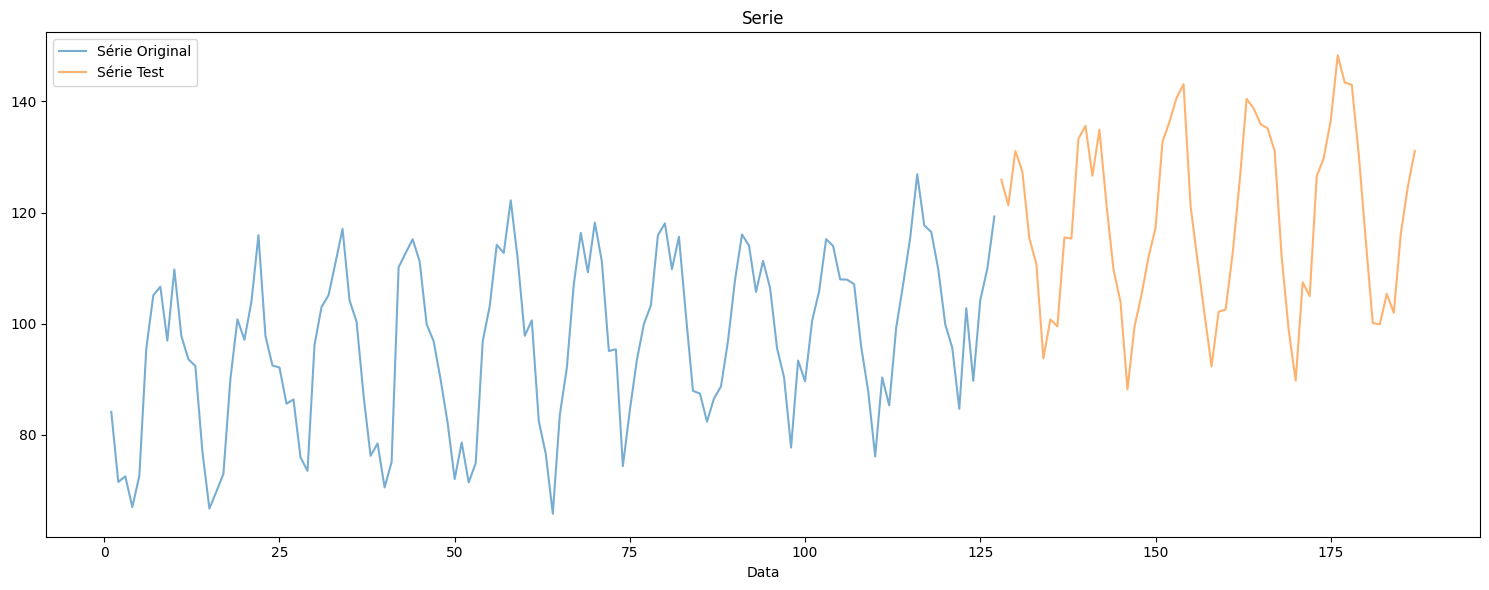

In [487]:
plt.figure(figsize=(15,6))

plt.plot(t, serie, label = 'Série Original', alpha = 0.6)
plt.plot(t_test, test, label = 'Série Test', alpha = 0.6)

plt.title('Serie')
plt.xlabel('Data')
plt.legend()
plt.tight_layout()
plt.show()

In [488]:
def holt_winters(serie, seasonality, a, c, d):

  Z_bar_initial = [np.nan] * seasonality
  T_hat_initial = [np.nan] * seasonality

  Z_bar_initial[-1] = (1 / seasonality) * sum(serie[:seasonality])
  F_hat_initial     = [Z_j/Z_bar_initial[-1] for Z_j in serie[:seasonality]]
  T_hat_initial[-1] = 0

  Z_bar = Z_bar_initial
  F_hat = F_hat_initial
  T_hat = T_hat_initial

  for t in range(seasonality, len(serie)):
    Z_bar_update = a * (serie[t] - F_hat[t - seasonality]) + (1 - a) * (Z_bar[t - 1] + T_hat[t - 1])
    Z_bar.append(Z_bar_update)

    T_hat_update = c * (Z_bar[-1] - Z_bar[-2]) + (1 - c) * T_hat[t - 1]
    T_hat.append(T_hat_update)

    F_hat_update = d * (serie[t] - Z_bar[-1]) + (1 - d) * F_hat[t - seasonality]
    F_hat.append(F_hat_update)

  Z_ajustado = [i + j + k for i, j, k in zip(Z_bar, T_hat, F_hat)]

  return Z_bar, T_hat, F_hat, Z_ajustado


def hw_forecast(h, Z_bar, T_hat, F_hat, seasonality, seasonality_start = 1):

  Z_bar_t = Z_bar[-1]
  T_hat_t = T_hat[-1]
  F_hat_t = F_hat[-seasonality:]

  forecast = []
  seasonality_start = seasonality_start - 1

  for i in range(1, h + 1):

    seasonality_factor = (i + seasonality_start - 1)  % seasonality

    z_h = Z_bar_t + (i * T_hat_t) + F_hat_t[seasonality_factor]
    forecast.append(z_h)

  return(forecast)

In [489]:
a = 0.3
c = 0.1
d = 0.3
seasonality = 12

In [490]:
Z_bar, T_hat, F_hat, Z_ajustado = holt_winters(serie, seasonality, a, c, d)

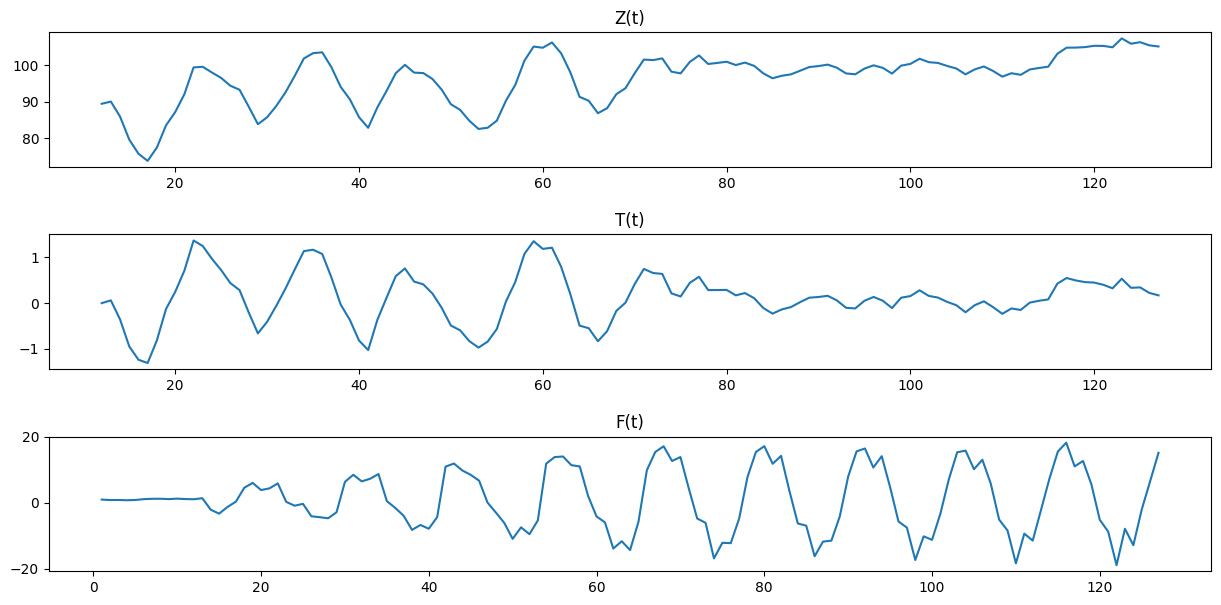

In [491]:
plt.figure(figsize=(15,7))

plt.subplot(3,1,1)
plt.plot(t, Z_bar)
plt.title("Z(t)")

plt.subplot(3,1,2)
plt.plot(t, T_hat)
plt.title("T(t)")

plt.subplot(3,1,3)
plt.plot(t, F_hat)
plt.title("F(t)")

plt.subplots_adjust(hspace=0.5)
plt.show()

Text(0.5, 1.0, 'Z(t)')

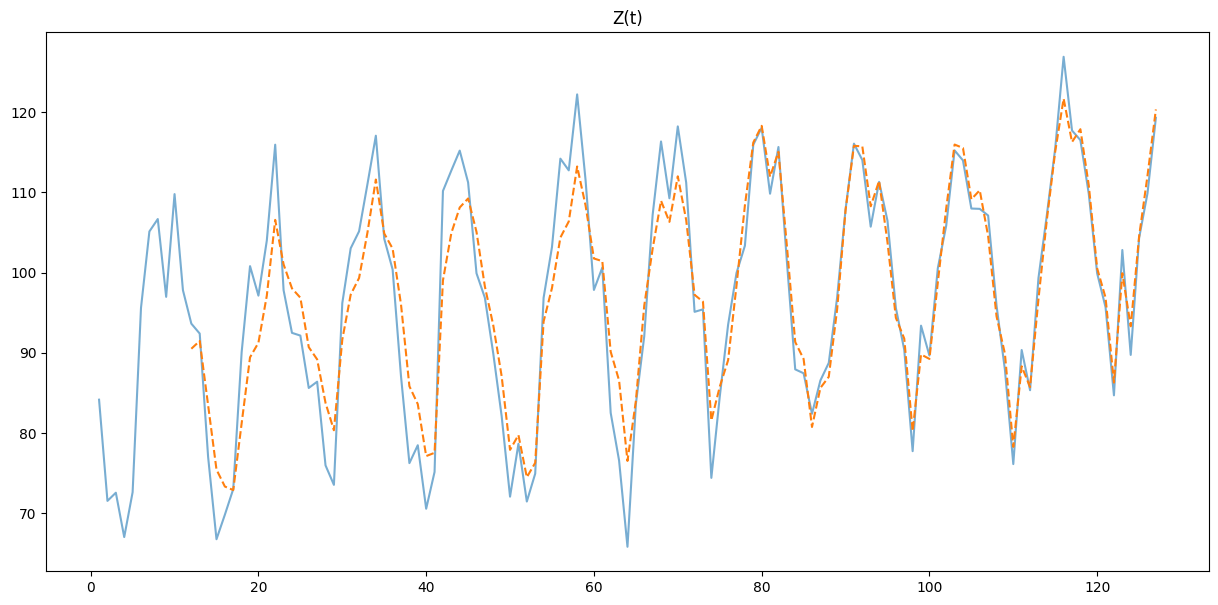

In [492]:
plt.figure(figsize=(15,7))

plt.plot(t, serie, label = 'Série Original', alpha = 0.6)
plt.plot(t, Z_ajustado, label='Ajustado', linestyle='dashed')
plt.title("Z(t)")

In [493]:
h = len(test)
forecast = hw_forecast(h = h, Z_bar = Z_bar, T_hat = T_hat, F_hat= F_hat, seasonality = seasonality)

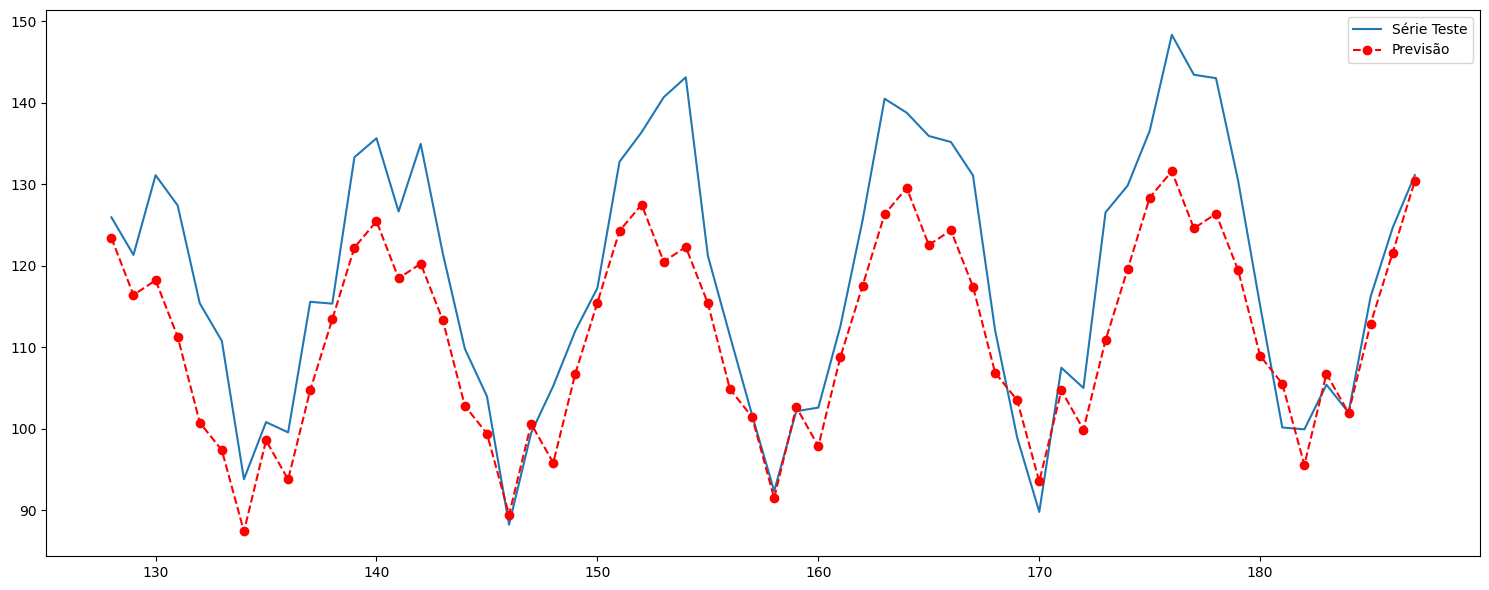

In [494]:
plt.figure(figsize=(15,6))

plt.plot(t_test, test, label = 'Série Teste')
plt.plot(t_test, forecast, color = 'red', marker='o', linestyle='dashed', label='Previsão')

plt.legend()
plt.tight_layout()
plt.show()

In [495]:
# def wh_rolling_forecast(serie, seasonality, a, c, d, h, seasonality_start = 1):

#   train_data = serie.to_list()
#   rolling_forecast = []

#   for i in range(h):
#     Z_bar, T_hat, F_hat,_ = holt_winters(train_data, seasonality, a, c, d)
#     forecast = hw_forecast(h = 1, Z_bar = Z_bar, T_hat = T_hat, F_hat= F_hat, seasonality = seasonality, seasonality_start = seasonality_start + i)[0]
#     train_data.append(forecast)
#     rolling_forecast.append(forecast)

#   return rolling_forecast

# rolling_forecast = wh_rolling_forecast(serie, seasonality, a, c, d, h, seasonality_start = 1)

# plt.figure(figsize=(15,6))

# plt.plot(t_test, test, label = 'Série Teste')
# plt.plot(t_test, forecast, color = 'red', marker='o', linestyle='dashed', label='Previsão')
# plt.plot(t_test, rolling_forecast, color = 'green', marker='o', linestyle='dashed', label='Previsão - rolling')

# plt.legend()
# plt.tight_layout()
# plt.show()

In [496]:
# Função de erro para otimização
def erro_hw(parametros, serie, seasonality, test_size):
    a, c, d = parametros  # Parâmetros que serão otimizados

    # Divisão da série em treino e teste
    train = serie[:-test_size]  # Série de treino
    test = serie[-test_size:]   # Série de teste

    # Aplicação do modelo Holt-Winters
    Z_bar, T_hat, F_hat, _ = holt_winters(train, seasonality, a, c, d)

    # Fazer previsão para o tamanho do período de teste
    forecast = hw_forecast(h=test_size, Z_bar=Z_bar, T_hat=T_hat, F_hat=F_hat, seasonality=seasonality)

    # Calcular erro (RMSE)
    erro = np.sqrt(np.mean((np.array(test) - np.array(forecast)) ** 2))  # RMSE

    return erro  # O objetivo é minimizar esse erro


# Tamanho do conjunto de teste (quantidade de pontos futuros que queremos testar)
serie_ajuste = df['ipialiment']
test_size = 60

# Definição de limites para os parâmetros (entre 0 e 1)
bounds = [(0, 1), (0, 1), (0, 1)]  # a, c, d devem estar entre 0 e 1

# Chute inicial para os parâmetros
parametros_iniciais = [0.5, 0.5, 0.5]

# Otimização usando o método 'L-BFGS-B'
resultado = minimize(erro_hw, parametros_iniciais, args=(serie_ajuste, seasonality, test_size), bounds=bounds, method='L-BFGS-B')

# Parâmetros ótimos encontrados
melhor_a, melhor_c, melhor_d = resultado.x

print(f"Melhores valores encontrados:")
print(f"a = {melhor_a:.4f}, c = {melhor_c:.4f}, d = {melhor_d:.4f}")

Melhores valores encontrados:
a = 0.5094, c = 0.0771, d = 0.1196


In [497]:
Z_bar, T_hat, F_hat, Z_ajustado_otimo = holt_winters(serie, seasonality, melhor_a, melhor_c, melhor_d)

In [498]:
h = len(test)
forecast = hw_forecast(h = h, Z_bar = Z_bar, T_hat = T_hat, F_hat= F_hat, seasonality = seasonality)

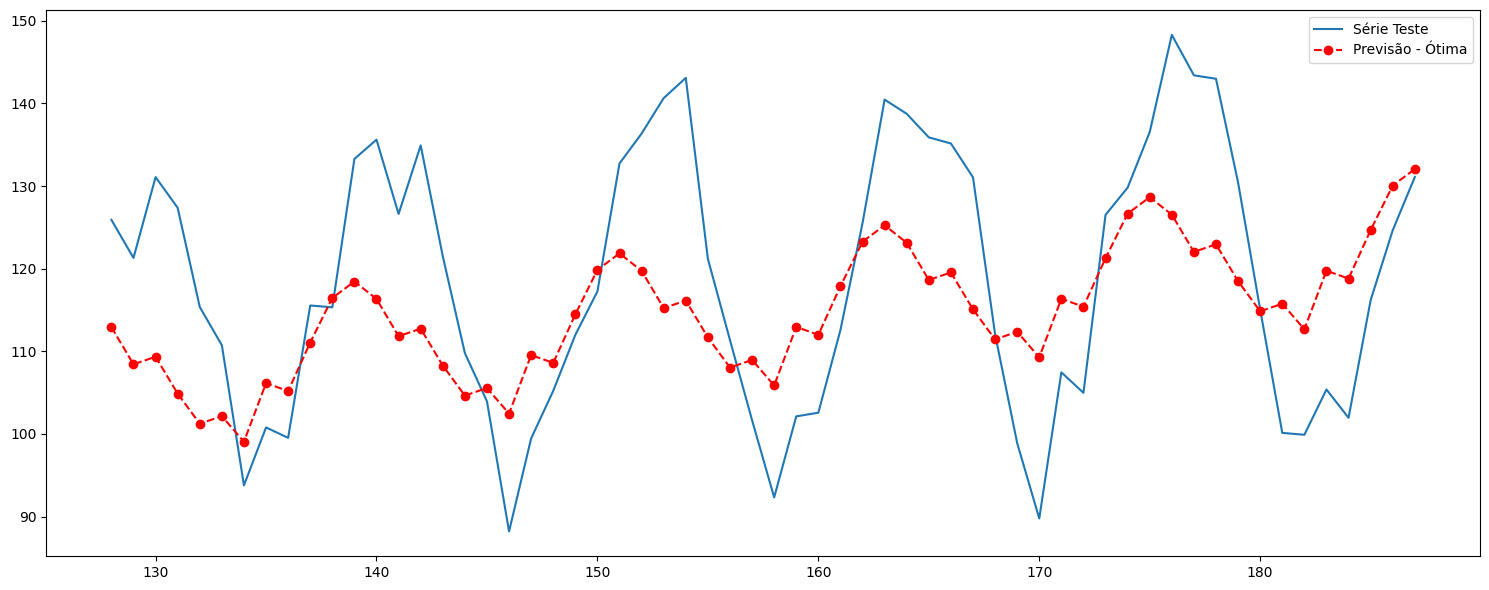

In [501]:
plt.figure(figsize=(15,6))

plt.plot(t_test, test, label = 'Série Teste')
plt.plot(t_test, forecast, color = 'red', marker='o', linestyle='dashed', label='Previsão - Ótima')

plt.legend()
plt.tight_layout()
plt.show()

Até o momento, todo o procedimento abordado se aplicou a séries aditivas. No entanto, quando lidamos com séries que apresentam um **fator sazonal multiplicativo $F(t)$**, a modelagem assume a seguinte forma:

$$Z(t) = \mu(t)F(t) + T(t) + a(t)$$


Para obter estimativas adequadas para esse tipo de série, é necessário realizar algumas adaptações nas equações de estimação, que podem ser expressas como:

$$\bar{Z}(t) = A[\frac{Z(t)}{\hat{F}(t - s)}] + (1 - A)[\bar{Z}(t - 1) + \hat{T}(t - 1)], \enspace 0 < A < 1, \enspace t = s + 1, \dots, N$$

$$\hat{T}(t) = C[\bar{Z}(t) - \bar{Z}(t - 1)] + (1 - C)\hat{T}(t - 1), \enspace 0 < C < 1, \enspace t = s + 1, \dots, N$$

$$\hat{F}(t) = D[\frac{Z(t)}{\bar{Z}(t)}] + (1 - D)\hat{F}(t - s), \enspace 0 < D < 1, \enspace t = s + 1, \dots, N$$

Já as previsões para o horizonte futuro assumem a seguinte estrutura:

$$ \bar{Z}_t(h) = [\bar{Z}(t) + h \hat{T}(t)]\hat{F}(t + h - s) → h = 1, 2, \dots, N$$

$$ \bar{Z}_t(h) = [\bar{Z}(t) + h \hat{T}(t)]\hat{F}(t + h - 2s) → h = s + 1, 2, \dots, N$$

A lógica para períodos extrapolados segue o mesmo princípio do modelo aditivo, garantindo a continuidade da sazonalidade ao longo do tempo.